1)  Show that the Wiener-Khichine theorem holds for the 2D variance
spectrum for Landsat A17.  That is
    show that integrating the power spectrum over :math:`k_x` and
:math:`k_y` yields the variance of theoptical depth.

    
1) Overall idea:
Variance: value at 0 lag in the autocorrelation
Power Spectrum: given by 

2)  Lowpass filter the Landsat scene so that fluctuations with spatial
scales less than 1 km are removed from the image.
    (make plots of the filtered image and its 1-d power spectrum)

In [8]:

import numpy as np
import warnings
warnings.filterwarnings("ignore",category=FutureWarning)
from matplotlib import pyplot as plt
import urllib
import os
filelist=['a17.nc']
data_download=True
if data_download:
    for the_file in filelist:
        url='http://clouds.eos.ubc.ca/~phil/docs/atsc500/data/{}'.format(the_file)
        urllib.request.urlretrieve(url,the_file)
#print("download {}: size is {:6.2g} Mbytes".format(the_file,os.path.getsize(the_file)*1.e-6))
from netCDF4 import Dataset
with Dataset(filelist[0]) as nc:
    tau=nc.variables['tau'][...]

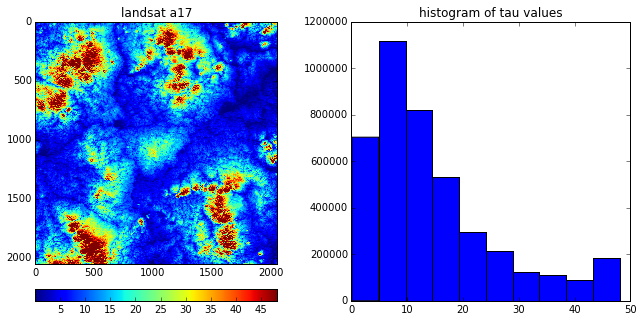

In [9]:
from matplotlib import pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.close('all')
fig,ax=plt.subplots(1,2,figsize=(11,5))
ax[0].set_title('landsat a17')
im0=ax[0].imshow(tau)
im1=ax[1].hist(tau.ravel())
ax[1].set_title('histogram of tau values')
divider = make_axes_locatable(ax[0])
cax = divider.append_axes("bottom", size="5%", pad=0.35)
out=fig.colorbar(im0,orientation='horizontal',cax=cax)


In [10]:

print(len(tau))
print(tau.shape)
tau_flat = tau.ravel()
print(tau_flat.shape)
tv = np.var(tau_flat)
print(tv)
tv = np.var(tau)
print(tv)

# from numpy import fft as 

# the_fft = fft.fft2(tau)
# auto_fft = the_fft*np.conj(the_fft)
# auto_fft = np.real(fft.ifft(auto_fft))
# fig,ax = plt.subplots(1,1,figsize=(10,8))
# ticks=np.arange(0,tau_flat.shape[0])#wvel.size)
# ticks=ticks/25.
# ax.plot(ticks[:300],auto_fft[:300])

# print(auto_fft.shape)

# print(numpy.amax(auto_fft))


2048
(2048, 2048)
(4194304,)
134.993
134.993


In [11]:
from netCDF4 import Dataset
import numpy as np
import math
from numpy import fft
from matplotlib import pyplot as plt


class ubc_fft:

    def __init__(self, filename, var, scale):
        """
           Input filename, var=variable name, 
           scale= the size of the pixel in km

           Constructer opens the netcdf file, reads the data and
           saves the twodimensional fft
        """
        with Dataset(filename,'r') as fin:
            data = fin.variables[var][...]
        data = data - data.mean()
        if data.shape[0] != data.shape[1]:
            raise ValueError('expecting square matrix')
        self.xdim = data.shape[0]     # size of each row of the array
        self.midpoint = int(math.floor(self.xdim/2))
        root,suffix = filename.split('.')
        self.filename = root
        self.var = var
        self.scale = float(scale)
        self.data = data
        self.fft_data = fft.fft2(self.data)
    
    def power_spectrum(self):
        """
           calculate the power spectrum for the 2-dimensional field
        """
        #
        # fft_shift moves the zero frequency point to the  middle
        # of the array  
        #
        fft_shift = fft.fftshift(self.fft_data)
        spectral_dens = fft_shift*np.conjugate(fft_shift)/(self.xdim*self.xdim)
        spectral_dens = spectral_dens.real
        #
        # dimensional wavenumbers for 2dim spectrum  (need only the kx
        # dimensional since image is square
        #
        k_vals = np.arange(0,(self.midpoint))+1
        k_vals = (k_vals-self.midpoint)/(self.xdim*self.scale)
        self.spectral_dens=spectral_dens
        self.k_vals=k_vals

    def annular_avg(self,avg_binwidth):
        """ 
         integrate the 2-d power spectrum around a series of rings 
         of radius kradial and average into a set of 1-dimensional
         radial bins
        """
        #
        #  define the k axis which is the radius in the 2-d polar version of E
        #
        numbins = int(round((math.sqrt(2)*self.xdim/avg_binwidth),0)+1)

        avg_spec = np.zeros(numbins,np.float64)
        bin_count = np.zeros(numbins,np.float64)

        print("\t- INTEGRATING... ")
        for i in range(self.xdim):
            if (i%100) == 0:
                print("\t\trow: {} completed".format(i))
            for j in range(self.xdim):
                kradial = math.sqrt(((i+1)-self.xdim/2)**2+((j+1)-self.xdim/2)**2)
                bin_num = int(math.floor(kradial/avg_binwidth))
                avg_spec[bin_num]=avg_spec[bin_num]+ kradial*self.spectral_dens[i,j]
                bin_count[bin_num]+=1

        for i in range(numbins):
            if bin_count[i]>0:
                avg_spec[i]=avg_spec[i]*avg_binwidth/bin_count[i]/(4*(math.pi**2))
        self.avg_spec=avg_spec
        #
        # dimensional wavenumbers for 1-d average spectrum
        #
        self.k_bins=np.arange(numbins)+1
        self.k_bins = self.k_bins[0:self.midpoint]
        self.avg_spec = self.avg_spec[0:self.midpoint]

        
    
    def graph_spectrum(self, kol_slope=-5./3., kol_offset=1., \
                      title=None):
        """
           graph the annular average and compare it to Kolmogorov -5/3
        """
        avg_spec=self.avg_spec
        delta_k = 1./self.scale                # 1./km (1/0.025 for landsat 25 meter pixels)
        nyquist = delta_k * 0.5
        knum = self.k_bins * (nyquist/float(len(self.k_bins)))# k = w/(25m)
        #
        # draw the -5/3 line through a give spot
        #
        kol = kol_offset*(knum**kol_slope)
        fig,ax=plt.subplots(1,1,figsize=(8,8))
        ax.loglog(knum,avg_spec,'r-',label='power')
        ax.loglog(knum,kol,'k-',label="$k^{-5/3}$")
        ax.set(title=title,xlabel='k (1/km)',ylabel='$E_k$')
        ax.legend()
        self.plotax=ax


In [12]:
plt.close('all')
plt.style.use('ggplot')
output = ubc_fft('a17.nc','tau',0.025)
output.power_spectrum()

In [13]:
def trapz2d(z,x=None,y=None,dx=1.,dy=1.):
    ''' Integrates a regularly spaced 2D grid using the composite trapezium rule. 
    IN:
       z : 2D array
       x : (optional) grid values for x (1D array)
       y : (optional) grid values for y (1D array)
       dx: if x is not supplied, set it to the x grid interval
       dy: if y is not supplied, set it to the x grid interval
    '''
    import numpy as N
    
    sum = N.sum
    if x != None:
        dx = (x[-1]-x[0])/(N.shape(x)[0]-1)
    if y != None:
        dy = (y[-1]-y[0])/(N.shape(y)[0]-1)    
    
    s1 = z[0,0] + z[-1,0] + z[0,-1] + z[-1,-1]
    s2 = sum(z[1:-1,0]) + sum(z[1:-1,-1]) + sum(z[0,1:-1]) + sum(z[-1,1:-1])
    s3 = sum(z[1:-1,1:-1])
    
    return 0.25*dx*dy*(s1 + 2*s2 + 4*s3)

In [14]:
# fig,ax=plt.subplots(1,1,figsize=(7,7))
# ax.set_title('landsat a17')
# im0=ax.imshow(np.log10(output.spectral_dens))
# ax.set_title('log10 of the 2-d power spectrum')
# # divider = make_axes_locatable(ax)
# # cax = divider.append_axes("bottom", size="5%", pad=0.35)
# out=fig.colorbar(im0,orientation='horizontal')
# plt.show()

powerspect = output.spectral_dens
spect_sq = powerspect*powerspect

silly = trapz2d(powerspect)
print(powerspect.size)
print(silly)
print(powerspect)



4194304
566199079.752
[[ 0.00225981  0.07968468  0.00515451 ...,  0.12634957  0.00515451
   0.07968468]
 [ 0.00758585  0.01896544  0.02718265 ...,  0.03895849  0.00804573
   0.00286147]
 [ 0.00636332  0.01819092  0.00112113 ...,  0.03487307  0.01724946
   0.003867  ]
 ..., 
 [ 0.01220721  0.02034118  0.0254587  ...,  0.00406826  0.02391435
   0.00037051]
 [ 0.00636332  0.003867    0.01724946 ...,  0.02017712  0.00112113
   0.01819092]
 [ 0.00758585  0.00286147  0.00804573 ...,  0.00649212  0.02718265
   0.01896544]]


2)  Lowpass filter the Landsat scene so that fluctuations with spatial
scales less than 1 km are removed from the image.
    (make plots of the filtered image and its 1-d power spectrum)

2.25


NameError: name 'numpy' is not defined

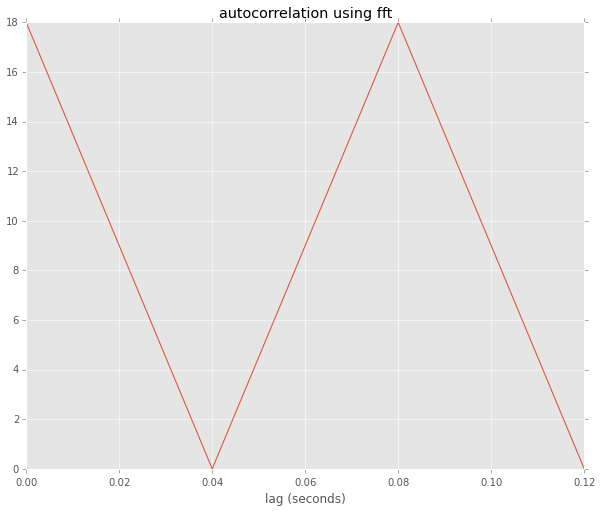

In [15]:
%matplotlib inline
wvel = [3, 0, 3, 0]
import numpy.fft as fft
the_fft = fft.fft(wvel)
auto_fft = the_fft*np.conj(the_fft)
auto_fft = np.real(fft.ifft(auto_fft))

fig,ax = plt.subplots(1,1,figsize=(10,8))
ticks=np.arange(0,len(wvel))#wvel.size)
ticks=ticks/25.
ax.plot(ticks[:300],auto_fft[:300])

out=ax.set(xlabel='lag (seconds)',title='autocorrelation using fft')


q = np.var(wvel)
print(q)


w = numpy.matrix([[2, 2,2],[2, 2,2],[2, 2,2],])
the_fft = fft.fft2(w)
auto_fft = the_fft*np.conj(the_fft)
auto_fft = np.real(fft.ifft(auto_fft))
fig,ax = plt.subplots(1,1,figsize=(10,8))
ticks=np.arange(0,3)#wvel.size)
ticks=ticks/25.
ax.plot(ticks[:300],auto_fft[:300])
